#### Download *modules*


---
\

In [ ]:
from flask import Flask, request, jsonify

In [ ]:
!pip install transformers

In [ ]:
import re

In [ ]:
import torch
from transformers import PreTrainedTokenizerFast
from transformers import GPT2LMHeadModel

model = GPT2LMHeadModel.from_pretrained('skt/kogpt2-base-v2')
tokenizer = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2",
                                                    bos_token='</s>', eos_token='</s>', unk_token='<unk>',
                                                    pad_token='<pad>', mask_token='<mask>')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/513M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.83M [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


In [ ]:
!pip install tqdm

### DATA PreProcessing

모델 학습에 사용되는 data 전처리
- 특수 문자 제거
- 문장 분리



---




In [ ]:
def read_data(txt_path):
  with open(txt_path, 'r') as f:
    txt_data = f.readlines()
  return txt_data

movie_ratings_data_path = "/content/Movie_Ratings(Naver).txt"   #이거 수정! 경로수정하시고

movie_ratings_data = read_data(movie_ratings_data_path) #data 바로 쓰면 되어요

In [ ]:
movie_ratings_data

['어릴 때 보고 지금 다시 봐도 재밌어요\n',
 '디자인을 배우는 학생으로 외국 디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업이 부러웠는데 사실 우리나라에서도 그 어려운 시절에 끝까지 열정을 지킨 노라노 같은 전통이 있어 저와 같은 사람들이 꿈을 꾸고 이뤄나갈 수 있다는 것에 감사합니다\n',
 '폴리스 스토리 시리즈는 1부터 뉴까지 버릴게 하나도 없음 최고\n',
 '와 연기가 진짜 개쩔구나 지루할 거라고 생각했는데 몰입해서 봤다 그래 이런 게 진짜 영화지\n',
 '안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화\n',
 '사랑을 해본 사람이라면 처음부터 끝까지 웃을 수 있는 영화\n',
 '정말 감동입니다 다시 봐도 감동\n',
 '개들의 전쟁 2 나오나요 나오면 1빠로 보고 싶음\n',
 '굿\n',
 '바보가 아니라 병 쉰인 듯\n',
 '내 나이와 같은 영화를 지금 본 나는 감동적이다 하지만 훗날 다시 보면 대사 하나하나 그 감정을 완벽하게 이해할 것만 같다\n',
 '재밌다\n',
 '고질라니 무 귀엽다는\n',
 '영화의 오페라화라고 해야 할 작품 극단적 평가를 림은 어쩔 수 없는 듯\n',
 '3도 반전 좋았지 \n',
 '평점 왜 낮아 긴장감 스릴감 진짜 최고인데 진짜 전장에서 느끼는 공포를 생생하게 전해준다\n',
 '네고시에이터랑 소재만 같을 뿐 아무런 관련 없음\n',
 '단연 최고\n',
 '가면 갈수록 더욱 빠져드네요 밀회 파이팅\n',
 '어 생각 없이 봤는데 상당한 수작 일본 영화 10년 내 최고로 마음에 들었다 강렬한 임팩트가 일품\n',
 '오랜만에 본 제대로 된 범죄 스릴러\n',
 '그런 때가 있었다 사랑해도 아니고 그저 좋아한다는 한 마디 말을 꺼내기도 벅차서 밤 잠 설치던 때 커징텅의 교복에 남은 션 사이의 볼펜 자국 역시 미처 다 전하지 못한 마음의 형태인 거다\n',
 '마지막 신을 잊을 수가 없다\n',
 '강압적 용서 세뇌적 용서에 대한 비판\n',
 '중세 시대 명작 굿 평점이 왜 이래\n',
 '

In [ ]:
len(movie_ratings_data)

150682

In [ ]:
# Preprocessing Data
# 각 줄에서 첫 번째 탭 문자 이전의 내용을 제거함 -> id 제거
# 이거는 Movie data 전처리라서 빼도 될거예요

def preprocess_data(txt_lines) :
  processed_lines = [] # 전처리된 문장이 저장될 공간

  for line in txt_lines:
      if '\t' in line:
          processed_lines.append(line.split('\t', 1)[1])

      else:
          processed_lines.append(line)

  final_data = []
  label = [] #긍정/부정 label -> 0:neg 1:pos
  for line in processed_lines:
      if '\t' in line:
          final_data.append(line.split('\t', 1)[0])
          label.append(line.split('\t', 1)[1][0])
      else:
          final_data.append(line)
  return final_data

movie_ratings_data = preprocess_data(movie_ratings_data)

In [ ]:
movie_ratings_data

['어릴 때 보고 지금 다시 봐도 재밌어요\n',
 '디자인을 배우는 학생으로 외국 디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업이 부러웠는데 사실 우리나라에서도 그 어려운 시절에 끝까지 열정을 지킨 노라노 같은 전통이 있어 저와 같은 사람들이 꿈을 꾸고 이뤄나갈 수 있다는 것에 감사합니다\n',
 '폴리스 스토리 시리즈는 1부터 뉴까지 버릴게 하나도 없음 최고\n',
 '와 연기가 진짜 개쩔구나 지루할 거라고 생각했는데 몰입해서 봤다 그래 이런 게 진짜 영화지\n',
 '안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화\n',
 '사랑을 해본 사람이라면 처음부터 끝까지 웃을 수 있는 영화\n',
 '정말 감동입니다 다시 봐도 감동\n',
 '개들의 전쟁 2 나오나요 나오면 1빠로 보고 싶음\n',
 '굿\n',
 '바보가 아니라 병 쉰인 듯\n',
 '내 나이와 같은 영화를 지금 본 나는 감동적이다 하지만 훗날 다시 보면 대사 하나하나 그 감정을 완벽하게 이해할 것만 같다\n',
 '재밌다\n',
 '고질라니 무 귀엽다는\n',
 '영화의 오페라화라고 해야 할 작품 극단적 평가를 림은 어쩔 수 없는 듯\n',
 '3도 반전 좋았지 \n',
 '평점 왜 낮아 긴장감 스릴감 진짜 최고인데 진짜 전장에서 느끼는 공포를 생생하게 전해준다\n',
 '네고시에이터랑 소재만 같을 뿐 아무런 관련 없음\n',
 '단연 최고\n',
 '가면 갈수록 더욱 빠져드네요 밀회 파이팅\n',
 '어 생각 없이 봤는데 상당한 수작 일본 영화 10년 내 최고로 마음에 들었다 강렬한 임팩트가 일품\n',
 '오랜만에 본 제대로 된 범죄 스릴러\n',
 '그런 때가 있었다 사랑해도 아니고 그저 좋아한다는 한 마디 말을 꺼내기도 벅차서 밤 잠 설치던 때 커징텅의 교복에 남은 션 사이의 볼펜 자국 역시 미처 다 전하지 못한 마음의 형태인 거다\n',
 '마지막 신을 잊을 수가 없다\n',
 '강압적 용서 세뇌적 용서에 대한 비판\n',
 '중세 시대 명작 굿 평점이 왜 이래\n',
 '

In [ ]:
for i in range(len(movie_ratings_data)) :
  movie_ratings_data[i] = movie_ratings_data[i].replace('\n','')

In [ ]:
movie_ratings_data

['어릴 때 보고 지금 다시 봐도 재밌어요',
 '디자인을 배우는 학생으로 외국 디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업이 부러웠는데 사실 우리나라에서도 그 어려운 시절에 끝까지 열정을 지킨 노라노 같은 전통이 있어 저와 같은 사람들이 꿈을 꾸고 이뤄나갈 수 있다는 것에 감사합니다',
 '폴리스 스토리 시리즈는 1부터 뉴까지 버릴게 하나도 없음 최고',
 '와 연기가 진짜 개쩔구나 지루할 거라고 생각했는데 몰입해서 봤다 그래 이런 게 진짜 영화지',
 '안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화',
 '사랑을 해본 사람이라면 처음부터 끝까지 웃을 수 있는 영화',
 '정말 감동입니다 다시 봐도 감동',
 '개들의 전쟁 2 나오나요 나오면 1빠로 보고 싶음',
 '굿',
 '바보가 아니라 병 쉰인 듯',
 '내 나이와 같은 영화를 지금 본 나는 감동적이다 하지만 훗날 다시 보면 대사 하나하나 그 감정을 완벽하게 이해할 것만 같다',
 '재밌다',
 '고질라니 무 귀엽다는',
 '영화의 오페라화라고 해야 할 작품 극단적 평가를 림은 어쩔 수 없는 듯',
 '3도 반전 좋았지 ',
 '평점 왜 낮아 긴장감 스릴감 진짜 최고인데 진짜 전장에서 느끼는 공포를 생생하게 전해준다',
 '네고시에이터랑 소재만 같을 뿐 아무런 관련 없음',
 '단연 최고',
 '가면 갈수록 더욱 빠져드네요 밀회 파이팅',
 '어 생각 없이 봤는데 상당한 수작 일본 영화 10년 내 최고로 마음에 들었다 강렬한 임팩트가 일품',
 '오랜만에 본 제대로 된 범죄 스릴러',
 '그런 때가 있었다 사랑해도 아니고 그저 좋아한다는 한 마디 말을 꺼내기도 벅차서 밤 잠 설치던 때 커징텅의 교복에 남은 션 사이의 볼펜 자국 역시 미처 다 전하지 못한 마음의 형태인 거다',
 '마지막 신을 잊을 수가 없다',
 '강압적 용서 세뇌적 용서에 대한 비판',
 '중세 시대 명작 굿 평점이 왜 이래',
 '7시간짜리 영상이 존재한다면 죽기 전에 꼭 한번 보고 싶다 아름답고 슬픈  제니퍼 코넬리의

In [ ]:
!pip install soynlp
from soynlp.normalizer import *
print(repeat_normalize('와하하하하하하하하하핫', num_repeats=2))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 416.8/416.8 kB 6.1 MB/s eta 0:00:00
와하하핫


In [ ]:
#문장 분리
!pip install kss
import kss
s = "회사 동료 분들과 다녀왔는데 분위기도 좋고 음식도 맛있었어요 다만, 강남 토끼정이 강남 쉑쉑버거 골목길로 쭉 올라가야 하는데 다들 쉑쉑버거의 유혹에 넘어갈 뻔 했답니다 강남역 맛집 토끼정의 외부 모습."
for sent in kss.split_sentences(s):
    print(sent)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.3/131.3 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.4/26.4 MB 34.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.3/180.3 kB 20.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 682.2/682.2 kB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 kB 56.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 66.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.2/72.2 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 kB 39.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

회사 동료 분들과 다녀왔는데 분위기도 좋고 음식도 맛있었어요
다만, 강남 토끼정이 강남 쉑쉑버거 골목길로 쭉 올라가야 하는데 다들 쉑쉑버거의 유혹에 넘어갈 뻔 했답니다
강남역 맛집 토끼정의 외부 모습.


In [ ]:
from tqdm import tqdm

new_movie_ratings_data = []
for oneline_data in tqdm(movie_ratings_data):
  for sent in kss.split_sentences(oneline_data) :
    new_movie_ratings_data.append(sent)

100%|██████████| 150682/150682 [05:07<00:00, 489.51it/s]


In [ ]:
len(new_movie_ratings_data)

196541

In [ ]:
b

['어릴 때 보고 지금 다시 봐도 재밌어요',
 '디자인을 배우는 학생으로 외국 디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업이 부러웠는데 사실 우리나라에서도 그 어려운 시절에 끝까지 열정을 지킨 노라노 같은 전통이 있어 저와 같은 사람들이 꿈을 꾸고 이뤄나갈 수 있다는 것에 감사합니다',
 '폴리스 스토리 시리즈는 1부터 뉴까지 버릴게 하나도 없음',
 '최고',
 '와 연기가 진짜 개쩔구나',
 '지루할 거라고 생각했는데 몰입해서 봤다',
 '그래 이런 게 진짜 영화지',
 '안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화',
 '사랑을 해본 사람이라면 처음부터 끝까지 웃을 수 있는 영화',
 '정말 감동입니다',
 '다시 봐도 감동',
 '개들의 전쟁 2 나오나요',
 '나오면 1빠로 보고 싶음',
 '굿',
 '바보가 아니라 병 쉰인 듯',
 '내 나이와 같은 영화를 지금 본 나는 감동적이다',
 '하지만 훗날 다시 보면 대사 하나하나 그 감정을 완벽하게 이해할 것만 같다',
 '재밌다',
 '고질라니 무 귀엽다는',
 '영화의 오페라화라고 해야 할 작품 극단적 평가를 림은 어쩔 수 없는 듯',
 '3도 반전 좋았지',
 '평점 왜 낮아 긴장감 스릴감 진짜 최고인데 진짜 전장에서 느끼는 공포를 생생하게 전해준다',
 '네고시에이터랑 소재만 같을 뿐 아무런 관련 없음',
 '단연 최고',
 '가면 갈수록 더욱 빠져드네요',
 '밀회 파이팅',
 '어 생각 없이 봤는데 상당한 수작 일본 영화 10년 내 최고로 마음에 들었다 강렬한 임팩트가 일품',
 '오랜만에 본 제대로 된 범죄 스릴러',
 '그런 때가 있었다 사랑해도 아니고 그저 좋아한다는 한 마디 말을 꺼내기도 벅차서 밤 잠 설치던 때 커징텅의 교복에 남은 션 사이의 볼펜 자국 역시 미처 다 전하지 못한 마음의 형태인 거다',
 '마지막 신을 잊을 수가 없다',
 '강압적 용서 세뇌적 용서에 대한 비판',
 '중세 시대 명작 굿 평점이 왜 이래',
 '7시간짜리 영상이 존재한다면 죽기 전에 꼭

In [ ]:
# Data Preprocessing
# 특수문자 제거, 반복되는 문자(ㅋㅋㅋㅋ, ??? 등) 제거

final_data = []

for i in tqdm(range(len(a))) :
  normalized_text = repeat_normalize(a[i], num_repeats=1)
  removed_alpa = re.sub('[|A-Za-z|]+', '', normalized_text)
  removed_special_char = re.sub('[^가-힣\s]', '', removed_alpa)
  final_data.append(removed_special_char)

100%|██████████| 196541/196541 [00:01<00:00, 108754.57it/s]


In [ ]:
# Data Preprocessing
# 특수문자 제거, 반복되는 문자(ㅋㅋㅋㅋ, ??? 등) 제거

final_data = []

for i in tqdm(range(len(b))) :
  normalized_text = repeat_normalize(b[i], num_repeats=1)
  removed_alpa = re.sub('[|A-Za-z|]+', '', normalized_text)
  final_data.append(removed_alpa)

100%|██████████| 196541/196541 [00:01<00:00, 124943.14it/s]


In [ ]:
final_data

['어릴 때 보고 지금 다시 봐도 재밌어요',
 '디자인을 배우는 학생으로 외국 디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업이 부러웠는데 사실 우리나라에서도 그 어려운 시절에 끝까지 열정을 지킨 노라노 같은 전통이 있어 저와 같은 사람들이 꿈을 꾸고 이뤄나갈 수 있다는 것에 감사합니다',
 '폴리스 스토리 시리즈는 1부터 뉴까지 버릴게 하나도 없음',
 '최고',
 '와 연기가 진짜 개쩔구나',
 '지루할 거라고 생각했는데 몰입해서 봤다',
 '그래 이런 게 진짜 영화지',
 '안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화',
 '사랑을 해본 사람이라면 처음부터 끝까지 웃을 수 있는 영화',
 '정말 감동입니다',
 '다시 봐도 감동',
 '개들의 전쟁 2 나오나요',
 '나오면 1빠로 보고 싶음',
 '굿',
 '바보가 아니라 병 쉰인 듯',
 '내 나이와 같은 영화를 지금 본 나는 감동적이다',
 '하지만 훗날 다시 보면 대사 하나하나 그 감정을 완벽하게 이해할 것만 같다',
 '재밌다',
 '고질라니 무 귀엽다는',
 '영화의 오페라화라고 해야 할 작품 극단적 평가를 림은 어쩔 수 없는 듯',
 '3도 반전 좋았지',
 '평점 왜 낮아 긴장감 스릴감 진짜 최고인데 진짜 전장에서 느끼는 공포를 생생하게 전해준다',
 '네고시에이터랑 소재만 같을 뿐 아무런 관련 없음',
 '단연 최고',
 '가면 갈수록 더욱 빠져드네요',
 '밀회 파이팅',
 '어 생각 없이 봤는데 상당한 수작 일본 영화 10년 내 최고로 마음에 들었다 강렬한 임팩트가 일품',
 '오랜만에 본 제대로 된 범죄 스릴러',
 '그런 때가 있었다 사랑해도 아니고 그저 좋아한다는 한 마디 말을 꺼내기도 벅차서 밤 잠 설치던 때 커징텅의 교복에 남은 션 사이의 볼펜 자국 역시 미처 다 전하지 못한 마음의 형태인 거다',
 '마지막 신을 잊을 수가 없다',
 '강압적 용서 세뇌적 용서에 대한 비판',
 '중세 시대 명작 굿 평점이 왜 이래',
 '7시간짜리 영상이 존재한다면 죽기 전에 꼭

In [ ]:
print(len(movie_ratings_data))
print(len(new_movie_ratings_data))
print(len(final_data))

150682
196541
196541


In [ ]:
import torch

class TextSet:
  def __init__(self, text_data, tokenizer, batch_len=8):
    self.text_in_a_string = "".join(text_data).replace('\n', ' ')
    self.tokenizer = tokenizer
    self.tokenized_corpus = self.tokenizer(self.text_in_a_string)['input_ids']
    self.batch_len = batch_len
    self.tokenized_corpus = self.tokenized_corpus[:len(self.tokenized_corpus)//self.batch_len*self.batch_len]
    self.corpus_tensor = self._batchify_text()

  def _batchify_text(self):
    entire_corpus_tensor = torch.LongTensor(self.tokenized_corpus)
    return entire_corpus_tensor.reshape(-1, self.batch_len)

  def __len__(self):
    return len(self.corpus_tensor)

  def __getitem__(self, idx):
    return self.corpus_tensor[idx]



In [ ]:
'''
define train_loader
'''

# 꼭!!! 데이터!!!!! 바꾸기!!!
train_data = final_data

from torch.utils.data import DataLoader
train_set = TextSet(train_data, tokenizer, batch_len=64)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)

100%|██████████| 500/500 [08:48<00:00,  1.06s/it]


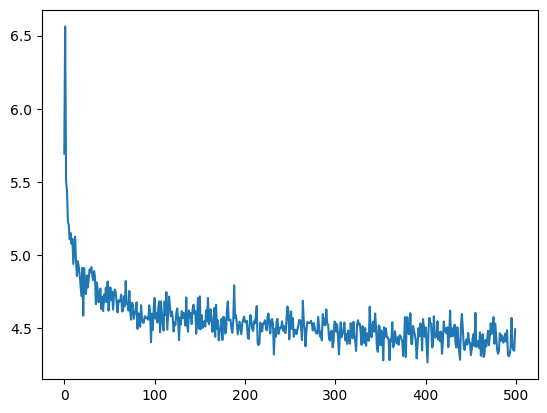

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm

'''
Use CUDA (NVIDIA GPU) to train your model
'''

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_record = []
model.cuda()
num_iteration = 500 # you can change num updates here

'''
In your report, briefly explain how this training loop trains a language model
'''
train_iter = iter(train_loader)

for i in tqdm(range(num_iteration)):
  try:
    batch = next(train_iter)
  except StopIteration:
    train_iter = iter(train_loader)
    batch = next(train_iter)
  out = model(batch.cuda()).logits
  out = torch.log_softmax(out, dim=-1)
  correct_next_word = batch[:, 1:]
  out_flatten = out[:, :-1, :].reshape(-1, out.shape[-1])
  correct_next_word = correct_next_word.reshape(-1)

  log_prob_of_correct_word = out_flatten[torch.arange(len(correct_next_word)), correct_next_word]

  loss = -log_prob_of_correct_word.mean()
  loss.backward()

  optimizer.step()
  optimizer.zero_grad()
  loss_record.append(loss.item())

plt.plot(loss_record)

In [ ]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
torch.save(model.state_dict(), 'movie_model.pt')

In [ ]:
torch.save(model.state_dict(), 'model_state_dict.pt')

### Generate Test


In [ ]:
"hi"

'hi'

In [ ]:
import torch
import random



def generate_sentence(prompt, max_length, temperature=0.9):
    # 입력 문장을 토크나이징
    random.seed(42)
    input_ids = tokenizer.encode(prompt, add_special_tokens=False, return_tensors='pt').cuda()

    # 문장 생성
    with torch.no_grad():
        outputs = model.generate(
            input_ids=input_ids.to(torch.device("cuda:0")),
            max_length=max_length,
            temperature=temperature,
            pad_token_id=tokenizer.eos_token_id,
            num_return_sequences=1,
            do_sample=True,  # 샘플링 활성화
            top_k=50,        # top_k 토큰 중에서 선택
            top_p=0.95
        )

    # 생성된 문장 디코딩
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    generated_text = generated_text.replace("\n", " ")
    generated_text = generated_text.replace('"', "")
    generated_text = generated_text.replace("'", "")
    return generated_text


In [ ]:
def generate_sentence(prompt, max_length, temperature=0.9):
    # 입력 문장을 토크나이징
    random.seed(42)
    input_ids = tokenizer.encode(prompt, return_tensors='pt').cuda()

    # 문장 생성
    with torch.no_grad():
        outputs = model.generate(
            input_ids=input_ids.to(torch.device("cuda:0")),
            max_length=max_length,
            temperature=temperature,
            pad_token_id=tokenizer.eos_token_id,
            num_return_sequences=1,
            do_sample=True,  # 샘플링 활성화
            top_k=50,        # top_k 토큰 중에서 선택
            top_p=0.95
        )

    # 생성된 문장 디코딩
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    generated_text = generated_text.replace("\n", " ")
    generated_text = generated_text.replace('"', "")
    generated_text = generated_text.replace("'", "")
    return generated_text


In [ ]:
generate_sentence("개노잼", 20, temperature=0.6)

'개노잼이네별 반 개도 아깝다 이거 뭔가요아놔'

In [ ]:
generate_sentence("바보아님", 20, temperature=0.9)

'바보아님들아내가 다행이네요평점 낮다 너무 낮아서 1점 줄게'

In [ ]:
generate_sentence("왜 이상하게 나올까요", 20, temperature=0.7)

'왜 이상하게 나올까요영화 자체가 해피엔딩이라 생각했는데 말이죠자살클럽'

In [ ]:
def make_acrostic(org, max_len):
  org_clean = org.replace(" ", "")
  syllables = list(org_clean)
  num_lines = len(syllables)
  print("====================================")
  print("prompt :", org)
  print("syllables :", syllables)
  print("max length of each sentence:", max_len)
  print("number of lines :", num_lines)

  generated_sentence = [""]
  lens = [0]

  for idx_n_letter in enumerate(syllables):
    i = idx_n_letter[0] #index
    one_letter = idx_n_letter[1] #실제 값


    concat_sentence = ""
    for one_sentence in generated_sentence:
      concat_sentence += one_sentence

    prompt = concat_sentence + one_letter
    # random.seed(30)
    # print(i, "prompt :", prompt)
    out = generate_sentence(prompt, max_length=max_len*(i+1))
    lens.append(len(out))
    # print(" ", "out :", out)
    # print(" ", "to save :", out[lens[i]:lens[i+1]])
    generated_sentence.append(out[lens[i]:lens[i+1]])

  print("---")
  del generated_sentence[0]
  for one_row in generated_sentence:
    one_row.strip()
    print(one_row)

  # print(lens)


In [ ]:
# Input 받아 저장

org = input("전하고 싶은 비밀 메시지를 입력하세요 : ")
# max_len = int(input("한 문장의 길이를 입력하세요 : "))
make_acrostic(org)

전하고 싶은 비밀 메시지를 입력하세요 : 개노잼
prompt : 개노잼
syllables : ['개', '노', '잼']
max length of each sentence: 20
number of lines : 3
---
개구리도 발암약인것 같음그냥 다 죽는거 같아요영화도 그냥
노잼이네요무뇌적인 성향보다는 오히려 이 더 심하다진짜 
잼 없음영화가 지루하고 웃기지도 않고 별로안웃긴거같던데그런데 평


In [ ]:
# Input 받아 저장

org = input("전하고 싶은 비밀 메시지를 입력하세요 : ")
# max_len = int(input("한 문장의 길이를 입력하세요 : "))
make_acrostic(org,20)

전하고 싶은 비밀 메시지를 입력하세요 : 재미없음
prompt : 재미없음
syllables : ['재', '미', '없', '음']
max length of each sentence: 20
number of lines : 4
---
재밌게 본 건 사실인데 평점이 너무 낮아서 아쉬웠는데 이런 좋은 영화도 많이
미국이 생각나는군요정말 감동적인 영화입니다실제로도 이런 일이 없었
없었으면 하는 생각이 드네요오타쿠들의 좋은 작품굿입니다최고의
음 정말 좋은 작품입니다재밌고 좋은데 평점이 왜 이리 높지 난 재밌


In [ ]:
# Input 받아 저장

org = input("전하고 싶은 비밀 메시지를 입력하세요 : ")
# max_len = int(input("한 문장의 길이를 입력하세요 : "))
make_acrostic(org,20)

전하고 싶은 비밀 메시지를 입력하세요 : 개노잼
prompt : 개노잼
syllables : ['개', '노', '잼']
max length of each sentence: 20
number of lines : 3
---
개도 아깝다 개 쓰레기 영화다솔직히 이건 너무 하네진짜 재미없
노 영화다 진심 이건 아니다 스토리 구성도 이상하고 액션도 이상하고 결말
잼이 없다진짜 지루하고 지루하고 허접하고 뭐가 허접하지 스토리가


In [ ]:
# Input 받아 저장

org = input("전하고 싶은 비밀 메시지를 입력하세요 : ")
# max_len = int(input("한 문장의 길이를 입력하세요 : "))
make_acrostic(org)

전하고 싶은 비밀 메시지를 입력하세요 : 개극혐
prompt : 개극혐
syllables : ['개', '극', '혐']
max length of each sentence: 10
number of lines : 3
first : 0, second : 개
first : 1, second : 극
first : 2, second : 혐
---
개재미있어요~~재밌음
극중 제일 멋있었는데 재밌게 본
혐지스럽지않다!!!!!


In [ ]:
# Input 받아 저장

org = input("전하고 싶은 비밀 메시지를 입력하세요 : ")
# max_len = int(input("한 문장의 길이를 입력하세요 : "))
make_acrostic(org)

전하고 싶은 비밀 메시지를 입력하세요 : 개극혐
prompt : 개극혐
syllables : ['개', '극', '혐']
max length of each sentence: 10
number of lines : 3
---
개쩜 재밌었네요. 왜 평점을
극삭임???지극히빙
혐지스럽게 잘생겼다 ᄏᄏ


In [ ]:
# Input 받아 저장

org = input("전하고 싶은 비밀 메시지를 입력하세요 : ")
# max_len = int(input("한 문장의 길이를 입력하세요 : "))
make_acrostic(org)

전하고 싶은 비밀 메시지를 입력하세요 : 노잼
prompt : 노잼
syllables : ['노', '잼']
max length of each sentence: 10
number of lines : 2
---
노마!!!기대안하고봤
잼이네요ᄒᄒᄒ ᅲ너


In [ ]:
# Input 받아 저장

org = input("전하고 싶은 비밀 메시지를 입력하세요 : ")
# max_len = int(input("한 문장의 길이를 입력하세요 : "))
make_acrostic(org)

전하고 싶은 비밀 메시지를 입력하세요 : 글쎄요
prompt : 글쎄요
syllables : ['글', '쎄', '요']
max length of each sentence: 20
number of lines : 3
---
글너무 잘 만들었습니다영화에서 나오는 메세지 하나하나가 최고야기대안하고
쎄쎄요공감합니다좋아요감동도 많이 받았구요특히 이쁜
요원작의 감성을 볼 수 있는 좋은 영화입니다그동안의 아쉬웠던 씁


In [ ]:
# Input 받아 저장

org = input("전하고 싶은 비밀 메시지를 입력하세요 : ")
# max_len = int(input("한 문장의 길이를 입력하세요 : "))
make_acrostic(org, 20)

전하고 싶은 비밀 메시지를 입력하세요 : 정말재밌음
prompt : 정말재밌음
syllables : ['정', '말', '재', '밌', '음']
max length of each sentence: 20
number of lines : 5
---
정정아 아역들도 잘생김아무말 안나온다정말 재밌
말아무리 평점이 낮은게 한이다여주인공들이 넘 좋아하다재밌다그런
재밌는  이영화도 재밌는데요아무것도 없었다는게 아쉬움재
밌게 봤던 영화그냥 스릴러가 아니던데최고가 더 좋다전
음마음이 따뜻해지네요평점점이 낮은 이유는  괜찮은 영화였어요


In [ ]:
org = "도망가"
length = 15
#org = input("전하고 싶은 비밀 메시지를 입력하세요 : ")
make_acrostic(org, length)

prompt : 도망가
syllables : ['도', '망', '가']
max length of each sentence: 15
number of lines : 3
---
도 도대체 뭐냐이건아니야다들 도대체 뭐
망쳐버리고말지진심개 노잼이다이런 쓰레기영
가왜 평점이 없는가 뭔 개같다점주는거임


In [ ]:
org = "고구마"
length = 15
#org = input("전하고 싶은 비밀 메시지를 입력하세요 : ")
make_acrostic(org, length)

prompt : 고구마
syllables : ['고', '구', '마']
max length of each sentence: 15
number of lines : 3
---
고감독이 망가지던데개쩌네왜이렇게 평점이
구만영구와 짱짱맨만 짱짱맨이래
마지막 장면은 왠만하면 절대 안 봐서 그런지 정말


In [ ]:
def make_acrostics(org,length):
  max_len=length
  org_clean = org.replace(" ", "")
  syllables = list(org_clean)
  num_lines = len(syllables)
  print("====================================")
  print("prompt :", org)
  print("syllables :", syllables)
  print("max length of each sentence:", max_len)
  print("number of lines :", num_lines)

  generated_sentence = [""]
  lens = [0]

  for idx_n_letter in enumerate(syllables):
    i = idx_n_letter[0]
    one_letter = idx_n_letter[1]

    concat_sentence = ""
    for one_sentence in generated_sentence:
      concat_sentence += one_sentence

    prompt = concat_sentence + ' '+ one_letter
    # random.seed(30)
    # print(i, "prompt :", prompt)
    out = generate_sentence(prompt, max_length=max_len*(i+1))
    # out = generate_sentence(prompt)
    lens.append(len(out))
    # print(" ", "out :", out)
    # print(" ", "to save :", out[lens[i]:lens[i+1]])
    generated_sentence.append(out[lens[i]:lens[i+1]])

  print("---")
  del generated_sentence[0]
  for one_row in generated_sentence:
    print(one_row.replace(' ',''))

  # print(lens)

In [ ]:
org = "바보"
make_acrostics(org)

prompt : 바보
syllables : ['바', '보']
max length of each sentence: 10
number of lines : 2
---
바기야정말재미없다정말
보다가끄면정말소름이돋는다


In [ ]:
org = "까까"
make_acrostics(org)

prompt : 까까
syllables : ['까', '까']
max length of each sentence: 10
number of lines : 2
---
까네
까네여이거보다가잤다진


In [ ]:
org = "재미있음"
make_acrostics(org)

prompt : 재미있음
syllables : ['재', '미', '있', '음']
max length of each sentence: 10
number of lines : 4
---
재미를떠나서좀유치하다좀짜증나
미친사람들은이영화보다섹시한
있네개쓰레기중의쓰레기영화별론
음도아까운그냥한쿡영화


In [ ]:
org = "노잼이에요"
make_acrostics(org)

prompt : 노잼이에요
syllables : ['노', '잼', '이', '에', '요']
max length of each sentence: 10
number of lines : 5
---
노임권용무협장르인듯
잼있네요이런게한국영화인데
이건좀아니다내가봤는데넘
에거슬리지않음영화도좋고재미
요즘세상에이런영화가없다지루


In [ ]:
org = "바아보"
make_acrostics(org,50)

prompt : 바아보
syllables : ['바', '아', '보']
max length of each sentence: 50
number of lines : 3
---
바스텔론너무멋있어요너무좋아요그냥이건머냐무슨말이필요한가도대체가아니고진짜웃김이제까지본영화중에가장재밌음진짜재밌
아요점케높네요역시잼있다재밌어요정말재밌어요정말최고의영화다재밌어요년영화인데년때만든건데아직도기억에남는다지금이걸
보느니괜찮은영화가나왔을지도모르겠네영화보다더나은영화였습니다굿쩔어진짜재미있게잼있어요최고감동너무재미있다아뭔가괜찮았는데평점이


In [ ]:
org = "진짜재밌음"
make_acrostics(org,20)

prompt : 진짜재밌음
syllables : ['진', '짜', '재', '밌', '음']
max length of each sentence: 20
number of lines : 5
---
진영희씨나와서이랬다질질끌다가끝난다빡치기대작
짜리는듯지루함돈내고보다가꺼버렸다돈주고도안봐도될
재탕노잼괜히봤어요지루하기만했습니다정말
밌어요정말감동적인작품입니다점준놈들이아닌데평점
음정말개실망이다이게뭐야이런영화에저런알바쓰다니정말영화


In [ ]:
!pip install git+https://github.com/ssut/py-hanspell.git
from hanspell import spell_checker

  Cloning https://github.com/ssut/py-hanspell.git to /tmp/pip-req-build-esvadg_j
  Running command git clone --filter=blob:none --quiet https://github.com/ssut/py-hanspell.git /tmp/pip-req-build-esvadg_j
  Resolved https://github.com/ssut/py-hanspell.git to commit fdc6ca50c19f1c85971437a072d89d4e5ce024b8
  Preparing metadata (setup.py) ... done


In [ ]:

# 맞춤법 및 띄어쓰기 교정
text = "바보같은 나의 모습"
corrected_sent = spell_checker.check(text)


KeyError: 'result'

In [ ]:
# Input 받아 저장

org = input("전하고 싶은 비밀 메시지를 입력하세요 : ")
# max_len = int(input("한 문장의 길이를 입력하세요 : "))
make_acrostic(org,20)

전하고 싶은 비밀 메시지를 입력하세요 : 개노잼
prompt : 개노잼
syllables : ['개', '노', '잼']
max length of each sentence: 20
number of lines : 3
---
개도 어째서 사귀가 않음이 영화 정말 짱임 그런 생각나서 이 영화를
노골든 트리오의 연기만으로 이 정도의 긴장감과 몰입도는짜응나는 감동이었
잼슴베로니카와 나나 그리고 인생은 아름답군대 갔다 왔었는데 평점이 왜


In [ ]:
# Input 받아 저장
make_acrostics("별로임",10)

prompt : 별로임
syllables : ['별', '로', '임']
max length of each sentence: 10
number of lines : 3
---
별연기도연출요리도너무좋은데아
로새끼들도제대로된목숨을걸어놓고싶
임그럼별10개입니다아무


In [ ]:
make_acrostics("기분이좋아요",15)

prompt : 기분이좋아요
syllables : ['기', '분', '이', '좋', '아', '요']
max length of each sentence: 15
number of lines : 6
---
기분좋았습니다감동적입니다소소하고
분절하고어지러운감정이들고냉정한사랑까지들었을때짐
이말한다마음한편에울컥하고가슴이울컥하네요
좋제멋있는노래베트남전쟁에대해다시생각하게되는영화평점
아깝지않네소소소한재미로잔인한영화처럼지루
요기계속계속봤어요이영화평점이너무낮다


In [ ]:
make_acrostics("절대보지마",15)

prompt : 절대보지마
syllables : ['절', '대', '보', '지', '마']
max length of each sentence: 15
number of lines : 5
---
절합니다너무재미있어너무재밌게보고
대박나기를바라네요와진짜진짜감동적이네요역
보시면후회안하실거예요진짜너무좋은결
지인들보면서다시보고싶은영화중하나네요영화에서지인들이
마들가게에가서보고있는데감동적이라며볼수있다해


In [ ]:
make_acrostics("절대보지마세요",20)

prompt : 절대보지마세요
syllables : ['절', '대', '보', '지', '마', '세', '요']
max length of each sentence: 20
number of lines : 7
---
절제이슨스타뎀자체로반은먹고들어갔다소설먼저보고폴워커의진정한매력이무엇인지
대박나세요제발고보는바보좀그만나와라그리고너를앗아가
보네감동적이었다뭐랄까아주재미있었다이영화덕분에앞으로도이렇게
지존적인영화한편이더많이상영될수있지않겠는가이런영화너무좋아요
마니아들이만쿤하스텝들을위해더만점을줘야되냐안보
세럽니깐하지만봐야겠다완전재미뜸얼른별점수를줘
요수치는거아저씨수준낮은것에10점넌점수주자놀다가웃


In [ ]:
generate_sentence("개노잼", 20, temperature=0.2)

'개노잼남포르는 짱인데 뭔가 좀 웃기다평점 좀 올리기'

In [ ]:
def make_acrostic_test1(org, max_len,temperature):
  org_clean = org.replace(" ", "")
  syllables = list(org_clean)
  num_lines = len(syllables)
  print("====================================")
  print("prompt :", org)
  print("syllables :", syllables)
  print("max length of each sentence:", max_len)
  print("number of lines :", num_lines)

  generated_sentence = [""]
  lens = [0]

  for idx_n_letter in enumerate(syllables):
    i = idx_n_letter[0] #index
    one_letter = idx_n_letter[1] #실제 값


    concat_sentence = ""
    for one_sentence in generated_sentence:
      concat_sentence += one_sentence

    prompt = concat_sentence + one_letter
    # random.seed(30)
    # print(i, "prompt :", prompt)
    out = generate_sentence(prompt, max_length=max_len*(i+1),temperature = temperature)
    lens.append(len(out))
    # print(" ", "out :", out)
    # print(" ", "to save :", out[lens[i]:lens[i+1]])
    generated_sentence.append(out[lens[i]:lens[i+1]])

  print("---")
  del generated_sentence[0]
  for one_row in generated_sentence:
    print(one_row.replace(' ',''))

  # print(lens)


In [ ]:
make_acrostic_test1("절대보지마세요",20,0.2)

prompt : 절대보지마세요
syllables : ['절', '대', '보', '지', '마', '세', '요']
max length of each sentence: 20
number of lines : 7
---
절절함이 느껴지는 명작정말 재밌게 봤는데요짱짱 넌 남자
대머리 콜린 퍼스라는 배우를 알게 해준 영화 콜린 퍼스 때문에 그녀가 행복
보단 덜떨어진다그리고 그녀의 나이는 아직 20대라는 걸로 봐서 10점 만
지작거절할 수 없는 매력덩어리들의 이야기 미셸 공들 이 둘의 매력
마지막에 더떨어지는 영화굳굳 다시 봐도 최고평점이 너무 낮네요재
세라 저능아비즌들은 볼 가치가 전혀 없는 영화정말 잘 만든 영화 정말 잘
요엄청난 심리묘사가 돋보이네요엄청춘의 사랑과 귀여운 여인의


In [ ]:
make_acrostic_test1("절대보지마세요",15,0.2)

prompt : 절대보지마세요
syllables : ['절', '대', '보', '지', '마', '세', '요']
max length of each sentence: 15
number of lines : 7
---
절절함이 느껴지는 명작솔직히 평점 왜 이래 다들
대작지금 세태에서 이 영화를 보면 알겠지만 그 당시엔
보면서 공포를 느낄 수 없었던 관점이 필요했다 영화 자체로만으로도 가치
지다고 생각함감각의 세계감을 느끼게 하는 감동적인 영화아주 어릴
마지막 부분 감동적이었다너무너무 좋았다어
세어렸을 때 진짜 재밌게 봤었거든요일단 캐
요이에서 하는 거 자꾸 캐스팅이 안 되는 게 문제더


In [ ]:
make_acrostic_test1("절대보지마세요",15,0.2)

prompt : 절대보지마세요
syllables : ['절', '대', '보', '지', '마', '세', '요']
max length of each sentence: 15
number of lines : 7
---
절절함이느껴지는명작정말재밌는영화였다다시
대와맞지않는부분이너무많은거같은데후반부스토리가
보면서약간늘어지는느낌이있었지만전체적으로좋았다마지막부분이인상적
지비내리는날생각나게하는영화였어요티브이에서할
마지막장면보고다시봐도재밌네요티브이에서할
세요영화인데평점너무낮네요영화볼만해요
요평론가님같은감정느끼는게아니라도영화볼만해요


In [ ]:
make_acrostic_test1("좋아요",15,0.1)

prompt : 좋아요
syllables : ['좋', '아', '요']
max length of each sentence: 15
number of lines : 3
---
좋다정말요전반적으로재밌게봤습니다
아쉬운건고등학생이라집에늦게와서감상하는게힘들었다는
요즘사는게너무아쉽다그냥좋다마지막장면은


In [ ]:
make_acrostic_test1("별로임",15,0.1)  temperature이 너무 높으면 안되는듯

prompt : 별로임
syllables : ['별', '로', '임']
max length of each sentence: 15
number of lines : 3
---
별별기대없이봤는데정말감동적이었습니다재미
로보는게아닌마음으로봤네요이런영화가많이만들어지
임감동도있었고재미도있었고감동도있었고정말재미있게


In [ ]:
make_acrostic_test1("개노잼",11,0.1)

prompt : 개노잼
syllables : ['개', '노', '잼']
max length of each sentence: 10
number of lines : 3
---
개네정말좋은영화감사합니다
노트북에이어내생의최고의로맨
잼작이걸보니까스토리자체가너무탄


In [ ]:
make_acrostic_test1("개노잼",12,0.1)

prompt : 개노잼
syllables : ['개', '노', '잼']
max length of each sentence: 12
number of lines : 3
---
개네정말재밌게본영화여운이남는
노골적이지않지만강한카타르시스그리고미스터백
잼이있는영화다평점왜이럼좋아요


In [ ]:
make_acrostic_test1("재미없음",15,0.1)

prompt : 재미없음
syllables : ['재', '미', '없', '음']
max length of each sentence: 15
number of lines : 4
---
재밌게봤던기억이난다정말어릴때본
미도재밌었지긴장감있고진짜재밌게
없나요이런영화가많이만들어지길바라며본영화너
음좋은영화다진짜재밌다웃긴감동이다스토


In [ ]:
make_acrostic_test1("재미없음",15,0.9)

prompt : 재미없음
syllables : ['재', '미', '없', '음']
max length of each sentence: 15
number of lines : 4
---
재밌고웃김내가좋아하는결말재재밌는영화였던
미안해지려고하는인간들나도행복해지고안행복해지는것이두
없을거야진짜미스터빈최고멋있다지금보면
음울할수도있다진짜이영화를다시봐야알았다


In [ ]:
make_acrostic_test1("재미없음",15,1.8)

prompt : 재미없음
syllables : ['재', '미', '없', '음']
max length of each sentence: 15
number of lines : 4
---
재밌습니다.친목사회라고했지만진짜웃음쩌네웃을수
미인간이지구를정복한날을보며우정을느끼는모습보고나도기분좋고재미있게
없잖았다고생각하지말길있으면제대로보고픈것에울었던정도먼
음씨와신서우깨아그리고서우연기력을과시하는


In [ ]:
make_acrostic_test1("재미없음",15,1.8)

prompt : 재미없음
syllables : ['재', '미', '없', '음']
max length of each sentence: 15
number of lines : 4
---
재밌다는느낌이다역삼동에사는아줌마가이정도인지
미드들의공통점의발견평점1점주는알바놈없소어
없자안웃긴다웃음과경배를갈기고싶은마음이가득
음다른사람들이안아줄수도없어도좋은곳이었음재밌게


In [ ]:
make_acrostic_test1("보지마세요",30,0.9)

prompt : 보지마세요
syllables : ['보', '지', '마', '세', '요']
max length of each sentence: 30
number of lines : 5
---
보보았나보다어이없다지루하고허세가득남김기덕감독의영화중하나이런영화첨써보는데이
지경때문에다들연기못하는듯요재미도없고그냥너무지루하게만듦재미는없고내용없는영화이런걸영화라고하는건
마지막장면이인상깊음영화보다재밌게봤는데지루하고진짜유치함너무나유치한영화네재미없고
세요평점이왜이렇게높은지모르겠음다참나재미없고내용도없고볼것도없다진짜재미없고내용도없고뭐
요재미없고그냥보는데이건아닌영화네뭐야1점도아까운영화내평점이다진짜이런영화들


In [ ]:
make_acrostic_test1("보지마세요",30,0.7)

prompt : 보지마세요
syllables : ['보', '지', '마', '세', '요']
max length of each sentence: 30
number of lines : 5
---
보려고했는데너무재밌고감동적이었습니다진짜웃기고감동적이었습니다사랑해요굿입니다진짜
지루하다재미가없다진부하다진짜재밌음1편보다훨씬재밌는듯그래도여배우가너무귀여
마음까지순수해지는영화임정말재미있었어요이거봤는데진심강추입니다무조건10점
세상에이런드라마너무재밌다너무감동적이고웃기고감동적인영화입니다정말재미있게봤어요정말
요정말웃기다정말웃기네요정말웃김하늘에서날아다니고싶다진짜웃기때문에이영화


In [ ]:
make_acrostic_test1("보세요",30,0.7)

prompt : 보세요
syllables : ['보', '세', '요']
max length of each sentence: 30
number of lines : 3
---
보는데저렇게하는게뭐야그냥어이없다영화내용은좀지루함그리고이게왜8점대라니진짜이거
세상에쓰레기같다정말지루하다어떻게이런영화만들수가없다최악의영화어휴어휴이건좀아닌듯
요정말이건좀아닌듯요이건뭐요유치해서재미없다유치하다재미없음이게영화냐유치해서평점10점


In [ ]:
make_acrostic_test1("도망가",30,0.7)

prompt : 도망가
syllables : ['도', '망', '가']
max length of each sentence: 30
number of lines : 3
---
도합니다재밌다재미없다는분들많으니깐보시길정말잘만든영화정말재밌는드라마였
망재밌음정말재밌어요아직안봤지만본방사수하고있습니다어릴때본건데도불구하고
가족과함께봤는데역시최고다재밌었음여주인공연기가너무너무이쁨굿굿굿굿굿이영화왜
